In [1]:
# ------------------------------------------------------------------------------ #
# What if scenarios for relaxations around May 11
# ------------------------------------------------------------------------------ #
%load_ext autoreload
%autoreload 2

import datetime
import copy
import sys

import pymc3 as pm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    import covid19_inference_new as cov19
except ModuleNotFoundError:
    sys.path.append("..")
    import covid19_inference_new as cov19


In [2]:
bd = datetime.datetime(2020, 3, 2)

jhu = cov19.data_retrieval.JHU()
jhu.download_all_available_data(force_download=True)
cum_cases = jhu.get_total(country="Germany", data_begin=bd)
new_cases = jhu.get_new(country="Germany", data_begin=bd)
print("Last data date: {}".format(new_cases.index[-1]))


params_model = dict(
    new_cases_obs=new_cases,
    data_begin=bd,
    fcast_len=80,
    diff_data_sim=16,
    N_population=83e6,
)

def make_cp_list(factor_dict, date_end):

    # change points like in the paper
    cp_list = [
        # mild distancing
        dict(
            # account for new implementation where transients_day is centered, not begin
            pr_mean_date_transient=datetime.datetime(2020, 3, 10),
            pr_median_transient_len=3,
            pr_sigma_transient_len=0.3,
            pr_sigma_date_transient=3,
            pr_median_lambda=0.2,
            pr_sigma_lambda=0.5,
        ),
        # strong distancing
        dict(
            pr_mean_date_transient=datetime.datetime(2020, 3, 17),
            pr_median_transient_len=3,
            pr_sigma_transient_len=0.3,
            pr_sigma_date_transient=1,
            pr_median_lambda=1 / 8,
            pr_sigma_lambda=0.5,
        ),
        # contact ban
        dict(
            pr_mean_date_transient=datetime.datetime(2020, 3, 24),
            pr_median_transient_len=3,
            pr_sigma_transient_len=0.3,
            pr_sigma_date_transient=1,
            pr_median_lambda=1 / 16,
            pr_sigma_lambda=0.5,
        ),
    ]
    pr_median_transient_len = 3
    pr_sigma_transient_len = 0.3
    pr_sigma_date_transient = 1
    last_date = datetime.datetime(2020, 3, 24)
    while True:
        date = last_date + datetime.timedelta(days=7)
        if date > date_end: break
        if date in factor_dict.keys():
            pr_factor_to_previous = factor_dict[date][0]
            print("use factor {} on {}".format(pr_factor_to_previous, date))
            pr_sigma_lambda=factor_dict[date][1]
        else:
            pr_factor_to_previous = 1
            pr_sigma_lambda = 0.15

        
        cp = dict(
            pr_mean_date_transient=date,
            pr_sigma_lambda = pr_sigma_lambda,
            pr_median_transient_len=pr_median_transient_len,
            pr_sigma_transient_len=pr_sigma_transient_len,
            pr_sigma_date_transient=pr_sigma_date_transient,
            relative_to_previous=True,
            pr_factor_to_previous = pr_factor_to_previous
        )
        cp_list.append(cp)
        last_date = date
    
    return cp_list

cp_a = make_cp_list({datetime.datetime(2020, 5, 12):[2, 0.01],
                     datetime.datetime(2020, 5, 5):[1, 0.02]}, datetime.datetime(2020, 5, 12))
cp_b = make_cp_list({datetime.datetime(2020, 5, 12):[1.5, 0.01],
                     datetime.datetime(2020, 5, 5):[1, 0.02]}, datetime.datetime(2020, 5, 12))
cp_c = make_cp_list({datetime.datetime(2020, 5, 12):[1, 0.01],
                     datetime.datetime(2020, 5, 5):[1, 0.02]}, datetime.datetime(2020, 5, 12))

def create_model(change_points, params_model):
    with cov19.Cov19Model(**params_model) as model:
        lambda_t_log = cov19.lambda_t_with_sigmoids(
            pr_median_lambda_0=0.4,
            pr_sigma_lambda_0=0.5,
            change_points_list=change_points,
        )

        mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
        pr_median_delay = 10

        prior_I = cov19.make_prior_I(lambda_t_log, mu, pr_median_delay=pr_median_delay)

        new_I_t = cov19.SIR(lambda_t_log, mu, pr_I_begin=prior_I)

        new_cases_inferred_raw = cov19.delay_cases(
            new_I_t, pr_median_delay=pr_median_delay, pr_median_scale_delay=0.3
        )

        new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)

        cov19.student_t_likelihood(new_cases_inferred)

    return model


mod_a = create_model(cp_a, params_model)
mod_b = create_model(cp_b, params_model)
mod_c = create_model(cp_c, params_model)



INFO     [covid19_inference_new.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference_new.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.
INFO     [covid19_inference_new.model_helper] relative_to_previous was set to default value False
INFO     [covid19_inference_new.model_helper] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference_new.model_helper] relative_to_previous was set to default value False
INFO     [covid19_inference_new.model_helper] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference_new.model_helper] relative_to_previous was set to default value False
INFO     [covid19_inference_new.model_helper] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference_new.model_helper] pr_median_lambda was set to default value 0.4
INFO     [covid19_inference_new.mode

Last data date: 2020-05-17 00:00:00
use factor 1 on 2020-05-05 00:00:00
use factor 2 on 2020-05-12 00:00:00
use factor 1 on 2020-05-05 00:00:00
use factor 1.5 on 2020-05-12 00:00:00
use factor 1 on 2020-05-05 00:00:00
use factor 1 on 2020-05-12 00:00:00


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '12958' (I am process '17237')
WARNING  [theano.gof.compilelock] Overriding existing lock by dead process '12958' (I am process '17237')
INFO     [covid19_inference_new.model_helper] relative_to_previous was set to default value False
INFO     [covid19_inference_new.model_helper] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference_new.model_helper] relative_to_previous was set to default value False
INFO     [covid19_inference_new.model_helper] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference_new.model_helper] relative_to_previous was set to default value False
INFO     [covid19_inference_new.model_helper] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference_new.model_helper] pr_median_lambda was set to default value 0.4
INFO     [covid19_inference_new.model_helper] pr_median_lambda was set to default value 0.4
INFO     [covid19_inferen

In [3]:
import pickle
tr_a = pm.sample(model=mod_a, tune=1000, draws=1000, init="advi+adapt_diag")
tr_b = pm.sample(model=mod_b, tune=1000, draws=1000, init="advi+adapt_diag")
tr_c = pm.sample(model=mod_c, tune=1000, draws=1000, init="advi+adapt_diag")
pickle.dump([(mod_a, mod_b, mod_c), (tr_a, tr_b, tr_c)], open('../data/what_if.pickled', 'wb'))

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 702.81:   9%|▊         | 17299/200000 [00:59<10:27, 291.22it/s]
Convergence achieved at 17300
INFO     [pymc3.variational.inference] Convergence achieved at 17300
Interrupted at 17,299 [8%]: Average Loss = 1,966.5
INFO     [pymc3.variational.inference] Interrupted at 17,299 [8%]: Average Loss = 1,966.5
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_

/home/sebastian/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


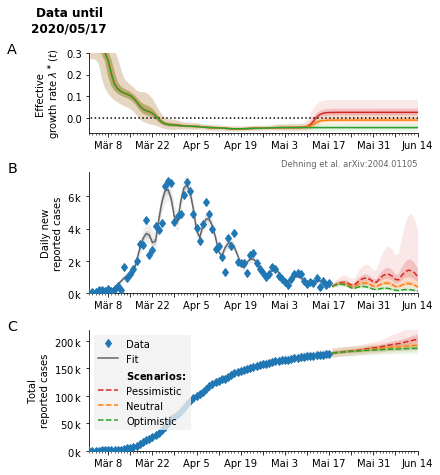

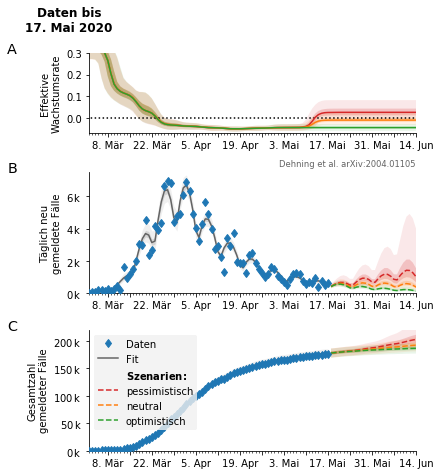

In [4]:
# ------------------------------------------------------------------------------ #
# plotting
# ------------------------------------------------------------------------------ #

# english
cov19.plot.set_rcparams(cov19.plot.get_rcparams_default())
cov19.plot.rcParams.draw_ci_50 = True

end = datetime.datetime(2020,6,14)

fig, axes = cov19.plot.timeseries_overview(
    mod_a,
    tr_a,
    offset=cum_cases[0],
    forecast_label="Pessimistic",
    forecast_heading=r"$\bf Scenarios\!:$",
    add_more_later=True,
    color="tab:red",

)


fig, axes = cov19.plot.timeseries_overview(
    mod_b,
    tr_b,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Neutral",
    color="tab:orange",
)

fig, axes = cov19.plot.timeseries_overview(
    mod_c,
    tr_c,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Optimistic",
    color="tab:green",
    end=end,
   
)
axes[0].set_ylim(-0.07,0.3)
axes[1].set_ylim(0,7500)
axes[2].set_ylim(0,220_000)

fig.savefig('../figures/what_if_english.pdf', dpi=300, bbox_inches="tight", pad_inches=0.05)
fig.savefig('../figures/what_if_english.png', dpi=300, bbox_inches="tight", pad_inches=0.05)

# german
cov19.plot.set_rcparams(cov19.plot.get_rcparams_default())
cov19.plot.rcParams.draw_ci_50 = True
cov19.plot.rcParams.locale = "de_DE"
cov19.plot.rcParams.date_format = "%-d. %b"

fig, axes = cov19.plot.timeseries_overview(
    mod_a,
    tr_a,
    offset=cum_cases[0],
    forecast_label="pessimistisch",
    forecast_heading=r"$\bf Szenarien\!:$",
    add_more_later=True,
    color="tab:red",
)


fig, axes = cov19.plot.timeseries_overview(
    mod_b,
    tr_b,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="neutral",
    color="tab:orange",
)

fig, axes = cov19.plot.timeseries_overview(
    mod_c,
    tr_c,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="optimistisch",
    color="tab:green",
    end=end
)

axes[0].set_ylim(-0.07,0.3)
axes[1].set_ylim(0,7500)
axes[2].set_ylim(0,220_000)

fig.savefig('../figures/what_if_german.pdf', dpi=300, bbox_inches="tight", pad_inches=0.05)
fig.savefig('../figures/what_if_german.png', dpi=300, bbox_inches="tight", pad_inches=0.05)

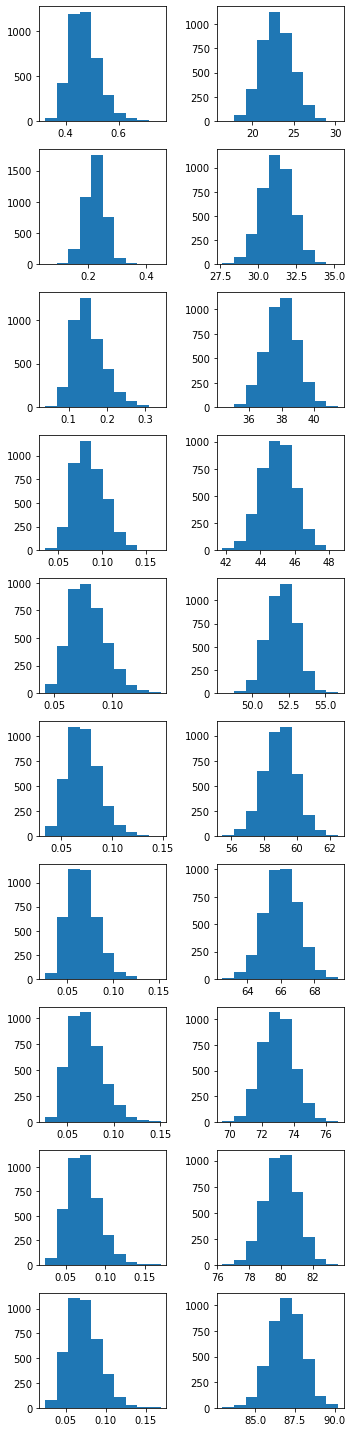

In [5]:
trace =tr_a
num_cps = 10
f, axes = plt.subplots(num_cps,2, figsize = (5,20))
for i in range(num_cps):
    ax = axes[i][0]
    ax.hist(trace[f'lambda_{i}'])
    
    ax = axes[i][1]
    ax.hist(trace[f'transient_day_{i+1}'])
plt.tight_layout()
plt.show()


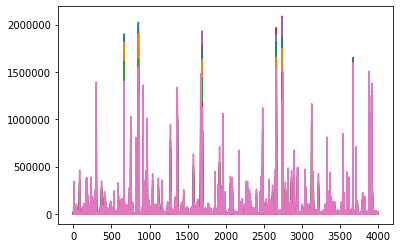

In [6]:
plt.plot(trace.new_cases)

In [7]:
print(np.median(trace.mu),np.median(trace.lambda_9), np.median(trace.lambda_10), np.median(trace.lambda_2))

0.1154360749694549 0.07097574749511212 0.14194040368504712 0.14665798920026824


In [8]:
1/8

0.125